# Computing Maximum Drawdown

In this lab, we'll develop the code to compute the maximum drawdown of a return series, and we'll start to develop our own module which will act as a toolkit that we will add to during the course.

First, let's read the return series we processed in the previous lab:


In [1]:
import pandas as pd

me_m = pd.read_csv("../data/Portfolios_Formed_on_ME_monthly_EW.csv",
                   header=0, index_col=0, parse_dates=True, na_values=-99.99)
rets = me_m[['Lo 20', 'Hi 20']]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets/100
rets.plot.line()

## Timeseries - forcing the index to be a datetime

We asked Pandas to `parse_dates` in `read_csv()`. Let's check if it was able to do so with the index:

In [2]:
rets.index

Int64Index([192607, 192608, 192609, 192610, 192611, 192612, 192701, 192702,
            192703, 192704,
            ...
            201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810,
            201811, 201812],
           dtype='int64', length=1110)

The `dtype` is `int64` which suggests that it was not automatically converted to a date time index, so let's do that now manually. The simplest way to force it to be a timeseries is by reformatting the index data to a `datetime` type as follows:

In [3]:
rets.index = pd.to_datetime(rets.index, format="%Y%m")
rets.index

DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=1110, freq=None)

Now that the DataFrame has a datetime index, we can treat the entire dataframe as a timeseries, which makes things very convenient. For instance, we can extract just the returns in 2008 as follows:

In [4]:
rets["2008"]

,SmallCap,LargeCap
2008-01-01,-0.0502,-0.0531
2008-02-01,-0.0270,-0.0278
2008-03-01,-0.0356,-0.0200
2008-04-01,0.0070,0.0560
2008-05-01,0.0289,0.0232
2008-06-01,-0.0891,-0.0964
2008-07-01,0.0074,-0.0219
2008-08-01,0.0172,0.0035
2008-09-01,-0.1163,-0.1238
2008-10-01,-0.2080,-0.2006


This looks good except that we know this is monthly data, and it's showing up with an index that is date stamped. We can fix this using the `to_period` method. We'll see several more examples of Pandas support for timeseries during the course.

In [5]:
rets.index = rets.index.to_period('M')
rets.head()

,SmallCap,LargeCap
1926-07,-0.0057,0.0333
1926-08,0.0384,0.0233
1926-09,-0.0048,-0.0009
1926-10,-0.0329,-0.0295
1926-11,-0.0055,0.0316


In [6]:
rets.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1110 entries, 1926-07 to 2018-12
Freq: M
Data columns (total 2 columns):
SmallCap    1110 non-null float64
LargeCap    1110 non-null float64
dtypes: float64(2)
memory usage: 26.0 KB


In [7]:
rets.describe()

,SmallCap,LargeCap
count,1110.000000,1110.000000
mean,0.015904,0.009434
std,0.097197,0.056325
min,-0.309900,-0.304000
25%,-0.026950,-0.019175
50%,0.011900,0.012300
75%,0.048300,0.038375
max,1.126000,0.416300


## Computing Drawdowns

1. Convert the time series of returns to a time series that represents a wealth index
2. Compute a time series of the previous peaks
3. Compute the Drawdown as the difference between the previous peak and the current value

Let's do this for Large Cap stocks.

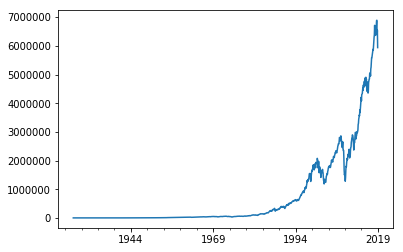

In [8]:
wealth_index = 1000*(1+rets["LargeCap"]).cumprod()
wealth_index.plot()

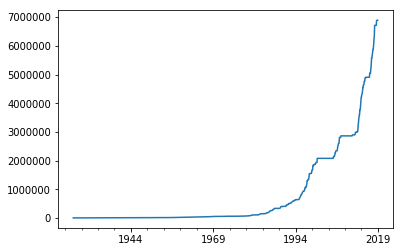

In [9]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot()

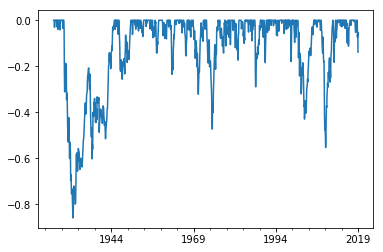

In [10]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot()

In [11]:
drawdown.min()

-0.8585017065044246

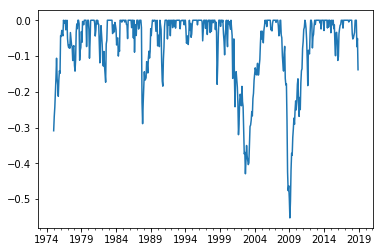

In [12]:
drawdown["1975":].plot()

In [13]:
drawdown["1975":].min()

-0.5527349978713652

# Creating a Drawdown Function

Redoing this analysis for SmallCap would be tedious, since we would need to re-enter all these commands at the prompt. Instead, let's create our first function that will form the first tool in our financial toolkit.

The function will take as input, a timeseries of returns, and return a timeseries as a DataFrame that contains the wealth index, the previous peaks and the drawdowns as a percent.

In [14]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

drawdown(rets["LargeCap"]).head()

,Wealth,Previous Peak,Drawdown
1926-07,1033.300000,1033.300000,0.000000
1926-08,1057.375890,1057.375890,0.000000
1926-09,1056.424252,1057.375890,-0.000900
1926-10,1025.259736,1057.375890,-0.030373
1926-11,1057.657944,1057.657944,0.000000


In [15]:
drawdown(rets["LargeCap"]).min()

Wealth            352.890879
Previous Peak    1033.300000
Drawdown           -0.858502
dtype: float64

In [16]:
drawdown(rets["SmallCap"]).min()

Wealth           321.764425
Previous Peak    994.300000
Drawdown          -0.867228
dtype: float64

In [17]:
drawdown(rets["LargeCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [18]:
drawdown(rets["SmallCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [19]:
drawdown(rets["LargeCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [20]:
drawdown(rets["SmallCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [21]:
drawdown(rets["SmallCap"]["1975":])["Drawdown"].min()

-0.6248092431236988